# A Dog on a Leash? (Part 1)

The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG. First, plot both price series, which look like random walks. Then plot the difference between the two series, which should look more like a mean reverting series (to put the two series in the same units, we multiply the heating oil prices, in dollar/gallon, by 7.25, which converts it to $/millionBTU, which is the same units as Natural Gas).

The data for continuous futures (each contract has to be spliced together in a continuous series as contracts expire) was obtained from Quandl.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
HO = pd.read_csv("dataset/CME_HO1.csv", parse_dates=["Date"], index_col="Date")
NG = pd.read_csv("dataset/CME_NG1.csv", parse_dates=["Date"], index_col="Date")
HO.head()
# len(HO)


,Close
Date,
2005-12-30,1.7280
2005-12-29,1.7030
2005-12-28,1.6825
2005-12-27,1.6370
2005-12-23,1.7053


In [13]:
NG.head()
# len(NG)


,Close
Date,
2005-12-30,11.225
2005-12-29,11.223
2005-12-28,11.431
2005-12-27,11.022
2005-12-23,12.283


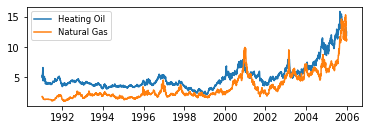

In [14]:
import matplotlib.pyplot as plt
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25*HO, label='Heating Oil')
plt.plot(NG, label='Natural Gas')
plt.legend(loc='best', fontsize='small')
plt.show()


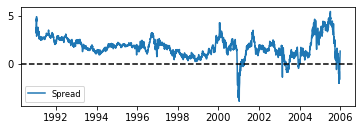

In [15]:

# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25*HO - NG, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

# A Dog on a Leash? (Part 2)

To verify that Heating Oil and Natural Gas prices are cointegrated, First apply the Dickey-Fuller test separately to show they are random walks. Then apply the test to the difference, which should strongly reject the random walk hypothesis. The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG.

In [16]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

# Compute the ADF for HO and NG
result_HO = adfuller(HO)
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread
result_spread = adfuller(7.25 * HO['Close'] - NG['Close'])
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on HO is  0.019831028071627756
The p-value for the ADF test on NG is  0.004547284956542337
The p-value for the ADF test on the spread is  0.00011887051827353336


# Are Bitcoin and Ethereum Cointegrated?

Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was 
. In other words, we took the difference between the two series (after doing a units conversion). Here, you will do both steps.

You will regress the value of one cryptocurrency, bitcoin (BTC), on another cryptocurrency, ethereum (ETH). If we call the regression coefficient 
, then the cointegration vector is simply 
. Then perform the ADF test on BTC 
 ETH. Bitcoin and Ethereum prices are pre-loaded in DataFrames BTC and ETH.

In [20]:
ETH = HO
BTC = NG
print(type(ETH))
print(type(BTC))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [23]:
# Import the statsmodels module for regression and the adfuller function
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Regress BTC on ETH
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC,ETH).fit()

# Compute ADF
b = result.params[1]
print("Co-efficient as slope = ", b)
adf_stats = adfuller(BTC['Close'] - b*ETH['Close'])
print("The p-value for the ADF test is ", adf_stats[1])

Co-efficient as slope =  6.37806784506032
The p-value for the ADF test is  2.1570947406257912e-05


# Is Temperature a Random Walk (with Drift)?

An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.

The DataFrame `temp_NY` contains the average annual temperature in Central Park, NY from 1870-2016 (the data was downloaded from the NOAA here). Plot the data and test whether it follows a random walk (with drift).

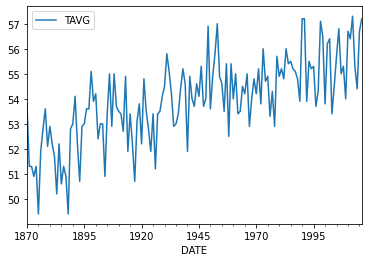

In [29]:
temp_NY = pd.read_csv("dataset/NOAA_TAVG.csv", parse_dates=["DATE"], index_col="DATE")
temp_NY.head()
temp_NY.plot()
plt.show()

In [30]:
# Import the adfuller function from the statsmodels module
from statsmodels.tsa.stattools import adfuller


# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])


The p-value for the ADF test is  0.5832938987871121


# Getting "Warmed" Up: Look at Autocorrelations

Since the temperature series, temp_NY, is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

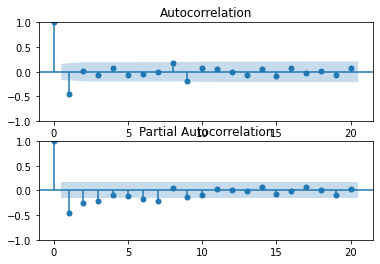

In [31]:
# Import the modules for plotting the sample ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

# Which ARMA Model is Best?

Recall from Chapter 3 that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

In [33]:
# Import the module for estimating an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1, 0, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(2, 0, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(1, 0, 1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No f

The AIC for an AR(1) is:  510.5346898733109
The AIC for an AR(2) is:  501.92741234091363
The AIC for an ARMA(1,1) is:  469.07291879070664


# Don't Throw Out That Winter Coat Yet

Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, you determined that the temperature data follows a random walk and you looked at first differencing the data. In this exercise, you will use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

Because temperatures are trending up over time, you will also need to add a trend component when you define the ARIMA model. In the exercise, you'll use a linear trend with time by setting the argument `trend='t'`. You can also try other trend models to see how the forecasts change.

c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


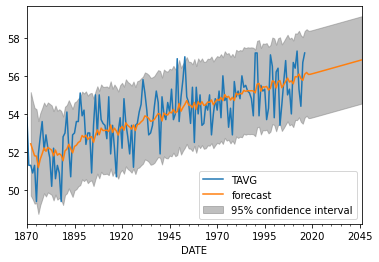

In [43]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, trend='t', order=(1,1,1)) # trend=[0,1,1] for quadratic
res = mod.fit()

# Plot the original series and the forecasted series
fig, ax = plt.subplots()
temp_NY.plot(ax=ax)
plot_predict(res, start='1872', end='2046', ax=ax)
plt.show()